In [1]:
import pandas as pd
from darts import TimeSeries
from darts.models import TiDEModel
from darts.metrics import mse, rmse, r2_score, mae, smape,wmape
from darts.dataprocessing.transformers import Scaler
import torch
from pytorch_lightning.callbacks import EarlyStopping
from sklearn.model_selection import TimeSeriesSplit
from plotnine import (
    ggplot, aes, geom_line, facet_wrap, labs, theme_bw, theme,
    element_text, element_blank, facet_grid
)
import json


torch.set_float32_matmul_precision('medium')


/home/eduardo/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/fs/__init__.py:4: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  __import__("pkg_resources").declare_namespace(__name__)  # type: ignore


In [2]:
target_columns = [
    'Temperature','Precipitation_accumulated','Humidity', 'Wind_Speed_kmh',
    'Soil_Moisture', 'Soil_Temperature', 'Wind_Dir_Sin', 'Wind_Dir_Cos'
]

DATA_FILE_PATH = "data/ground_station_clean.csv"
df = pd.read_csv(DATA_FILE_PATH)

In [3]:
encoders = {
    "cyclic": {
        "past": ["month", "dayofyear", "day", "hour", "minute"],
        "future": ["month", "dayofyear", "day", "hour", "minute"]
    },
    "transformer": Scaler(),
    "datetime_attribute": {
        "past": ["year"],
        "future": ["year"]
    }
}

In [4]:
best_mse = float('inf')
best_fold = -1
best_train_scaled = None
best_val_scaled = None
best_scaler = None
best_metrics = None
best_forecasts = None
# Definir parâmetros do modelo

# Listas para armazenar dados de todos os folds
all_forecasts = []
all_val_scaled = []
all_scalers = []
all_metrics_dfs = []
all_mse_scores = []
all_train_scaled = []
all_metrics_horizon = []

tscv = TimeSeriesSplit(n_splits=5)
fold_metrics = []
for fold, (train_idx, val_idx) in enumerate(tscv.split(df)):

    early_stopper = EarlyStopping("val_loss", min_delta=0.001, patience=10, verbose=True)
    pl_trainer_kwargs = {
        "accelerator": "auto",
        "callbacks": [early_stopper],
    }
    train_df_fold, val_df_fold = df.iloc[train_idx], df.iloc[val_idx]
    train_fold = TimeSeries.from_dataframe(train_df_fold, time_col="Timestamp", value_cols=target_columns, freq='1h')
    val_fold = TimeSeries.from_dataframe(val_df_fold, time_col="Timestamp", value_cols=target_columns, freq='1h')

    print(f"\n{'='*50}\nFold {fold+1}\n{'='*50}")
    print("\nTreinando o modelo...")
    print(f"Train set: {train_fold.shape[0]} samples")
    print(f"Validation set: {val_fold.shape[0]} samples")

    scaler = Scaler()
    # Ajustar o scaler apenas nos dados de treino para evitar data leakage
    scaler = scaler.fit(train_fold)
    # Transformar todas as séries
    train_scaled = scaler.transform(train_fold)
    val_scaled = scaler.transform(val_fold)


    model = TiDEModel(
        model_name=f"model_{fold+1}",
        input_chunk_length=24,
        output_chunk_length=24,
        num_encoder_layers=3,
        num_decoder_layers=2,
        hidden_size=144,
        temporal_width_past=3,
        temporal_width_future=1,
        temporal_hidden_size_future= 144,
        temporal_hidden_size_past=36,
        use_reversible_instance_norm=True,
        n_epochs=100,
        batch_size=64,
        dropout=0.4,
        add_encoders=encoders,
        pl_trainer_kwargs=pl_trainer_kwargs,
        loss_fn=torch.nn.SmoothL1Loss(),
        optimizer_cls=torch.optim.Adam,
        lr_scheduler_cls=torch.optim.lr_scheduler.ReduceLROnPlateau,
        lr_scheduler_kwargs={"mode": "min", "factor": 0.3, "patience": 5, "min_lr": 1e-7},
        save_checkpoints=True,
        show_warnings=True,
        force_reset=True,
        random_state=42,
        optimizer_kwargs={"lr": 0.004149646453870474, "weight_decay":0.001234370270520789}
    )
    model.fit(
        series=train_scaled,
        val_series=val_scaled,
        dataloader_kwargs={"num_workers": 11},
        verbose=False,
    )

    model.load_from_checkpoint(f"model_{fold+1}/", best=True)

    metrics_per_horizon = []
    for i in [1,4,8,12,16,20,24]:
        forecasts = model.historical_forecasts(
            val_scaled,
            forecast_horizon=i,
            stride=1,
            retrain=False,
            verbose=False,
            last_points_only=True,
        )

        forecasts_t = scaler.inverse_transform(forecasts)
        s = scaler.inverse_transform(val_scaled)
        metrics = {}
        print("Iniciando a verificação das séries temporais para constância...")
        try:
            for target in target_columns:
                metrics[target] = {
                    'MSE': mse(s[target], forecasts_t[target]),
                    'RMSE': rmse(s[target], forecasts_t[target]),
                    'MAE': mae(s[target], forecasts_t[target]),
                    'R2': r2_score(s[target], forecasts_t[target]),
                    'SMAPE': smape(s[target], forecasts_t[target]),
                    'WMAPE': wmape(s[target], forecasts_t[target]),
                }
            metrics_df = pd.DataFrame(metrics).T
            print("\nMétricas de performance:")
            print(metrics_df)
            metrics_per_horizon.append(metrics_df)
        except Exception as e:
            print(e)

    mse_geral = mse(s, forecasts_t)
    print(f"O MSE desse fold foi {mse_geral}")

    # Armazenar dados deste fold
    all_forecasts.append(forecasts)
    all_val_scaled.append(val_scaled)
    all_scalers.append(scaler)
    all_metrics_dfs.append(metrics_df)
    all_metrics_horizon.append(metrics_per_horizon)
    all_mse_scores.append(mse_geral)
    all_train_scaled.append(train_scaled)

    # Ainda mantemos o melhor fold para referência (agora baseado no MSE)
    if best_mse > mse_geral:
        best_mse = mse_geral
        best_fold = fold + 1
        best_train_scaled = train_scaled
        best_scaler = scaler
        best_metrics = metrics_df
        best_forecasts = forecasts
        best_val_scaled = val_scaled

print(f"O melhor fold (baseado no menor MSE) foi {best_fold}")

# Calcular a média dos R2 e MSE de todos os folds
avg_mse = sum(all_mse_scores) / len(all_mse_scores)
print(f"A média dos MSE de todos os folds foi {avg_mse:.4f}")

avg_metrics = {}
metric_names = ['MSE', 'RMSE', 'MAE', 'R2', 'SMAPE', 'WMAPE'] # Definir nomes das métricas

for target in target_columns:
    avg_metrics[target] = {} # Inicializar dicionário para o target atual
    for metric_name in metric_names:
        metric_values_for_fold = []
        # Coletar todos os valores válidos da métrica para o target atual em todos os folds
        for df_fold in all_metrics_dfs:
            # Verificar se o target existe como índice e a métrica como coluna no df_fold
            if target in df_fold.index and metric_name in df_fold.columns:
                value = df_fold.loc[target, metric_name]
                # Adicionar à lista apenas se não for NaN
                if pd.notna(value):
                    metric_values_for_fold.append(value)
        
        # Calcular a média apenas se houver valores válidos
        if metric_values_for_fold:
            avg_metrics[target][metric_name] = sum(metric_values_for_fold) / len(metric_values_for_fold)
        else:
            # Caso contrário, registrar NaN (ou outro valor padrão, se preferir)
            avg_metrics[target][metric_name] = float('nan')

avg_metrics_df = pd.DataFrame(avg_metrics).T
print("\nMétricas médias de performance de todos os folds:")
print(avg_metrics_df)


with open('all_metrics_horizon.json', 'w') as f:
    all_metrics_horizon_dict = [
        [df.to_dict() for df in fold_metrics] for fold_metrics in all_metrics_horizon
    ]
    json.dump(all_metrics_horizon_dict, f, indent=4)

# Salvar métricas médias
with open('avg_metrics.json', 'w') as f:
    json.dump(avg_metrics_df.to_dict(), f, indent=4)

print("\nUsando a média dos folds para análise...")

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Fold 1

Treinando o modelo...
Train set: 1389 samples
Validation set: 1384 samples


Metric val_loss improved. New best score: 0.351
Metric val_loss improved by 0.006 >= min_delta = 0.001. New best score: 0.345
Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.343
Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.341
Metric val_loss improved by 0.010 >= min_delta = 0.001. New best score: 0.331
Metric val_loss improved by 0.008 >= min_delta = 0.001. New best score: 0.323
Metric val_loss improved by 0.011 >= min_delta = 0.001. New best score: 0.312
Metric val_loss improved by 0.016 >= min_delta = 0.001. New best score: 0.296
Metric val_loss improved by 0.012 >= min_delta = 0.001. New best score: 0.283
Metric val_loss improved by 0.011 >= min_delta = 0.001. New best score: 0.272
Metric val_loss improved by 0.005 >= min_delta = 0.001. New best score: 0.267
Monitored metric val_loss did not improve in the last 10 records. Best score: 0.267. Signaling Trainer to stop.
GPU available: True (cuda), used: True
TPU available: False,

Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                    MSE        RMSE         MAE        R2  \
Temperature                    6.655470    2.579820    1.940658  0.854368   
Precipitation_accumulated    468.841204   21.652741    3.109302  0.988608   
Humidity                      37.455550    6.120094    4.801592  0.875118   
Wind_Speed_kmh                 0.210898    0.459236    0.338201  0.557263   
Soil_Moisture              64922.163361  254.798280  140.479687  0.946569   
Soil_Temperature              10.764395    3.280914    2.433574  0.809552   
Wind_Dir_Sin                   0.174789    0.418077    0.303073  0.507373   
Wind_Dir_Cos                   0.184613    0.429667    0.295722  0.671159   

                                SMAPE      WMAPE  
Temperature                 14.794283  11.744949  
Precipitation_accumulated    1.813975   2.335757  
Humidity                     6.832511   6.294112  
Wind_Speed_k

/home/eduardo/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: PossibleUserWarning: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                     MSE        RMSE         MAE        R2  \
Temperature                    10.225454    3.197726    2.451662  0.776515   
Precipitation_accumulated     645.244483   25.401663    3.530508  0.984342   
Humidity                       63.863301    7.991452    6.344409  0.787521   
Wind_Speed_kmh                  0.276413    0.525750    0.394730  0.420753   
Soil_Moisture              116549.946069  341.394121  190.682987  0.904232   
Soil_Temperature               14.928376    3.863726    2.889200  0.736201   
Wind_Dir_Sin                    0.221088    0.470200    0.348760  0.378220   
Wind_Dir_Cos                    0.238140    0.487995    0.342682  0.575919   

                                SMAPE      WMAPE  
Temperature                 18.528749  14.828435  
Precipitation_accumulated    2.442096   2.646438  
Humidity                     9.090287   8.317360  
Win

/home/eduardo/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: PossibleUserWarning: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                     MSE        RMSE         MAE        R2  \
Temperature                    11.164345    3.341309    2.582451  0.756427   
Precipitation_accumulated    1151.766045   33.937679    4.840098  0.972098   
Humidity                       73.063535    8.547721    6.723120  0.757269   
Wind_Speed_kmh                  0.278124    0.527375    0.397828  0.417960   
Soil_Moisture              153675.255831  392.014357  221.256916  0.873997   
Soil_Temperature               14.655326    3.828227    2.865322  0.741538   
Wind_Dir_Sin                    0.237507    0.487347    0.367071  0.332422   
Wind_Dir_Cos                    0.260764    0.510651    0.359552  0.536166   

                                SMAPE      WMAPE  
Temperature                 19.663004  15.607584  
Precipitation_accumulated    3.374786   3.617612  
Humidity                     9.624317   8.817524  
Win

/home/eduardo/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: PossibleUserWarning: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                     MSE        RMSE         MAE        R2  \
Temperature                    11.823873    3.438586    2.675894  0.742479   
Precipitation_accumulated    1671.965109   40.889670    6.258730  0.959565   
Humidity                       78.255388    8.846208    6.926518  0.740697   
Wind_Speed_kmh                  0.290939    0.539387    0.407800  0.392196   
Soil_Moisture              184910.806277  430.012565  243.871476  0.848637   
Soil_Temperature               15.025524    3.876277    2.931080  0.735084   
Wind_Dir_Sin                    0.246684    0.496673    0.374666  0.308543   
Wind_Dir_Cos                    0.270878    0.520460    0.364990  0.518338   

                                SMAPE      WMAPE  
Temperature                 20.571578  16.182326  
Precipitation_accumulated    4.355721   4.664380  
Humidity                     9.867874   9.083243  
Win

/home/eduardo/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: PossibleUserWarning: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                     MSE        RMSE         MAE        R2  \
Temperature                    12.541326    3.541374    2.752536  0.726740   
Precipitation_accumulated    2156.631792   46.439550    7.589453  0.947934   
Humidity                       82.833091    9.101269    7.145443  0.725983   
Wind_Speed_kmh                  0.294102    0.542312    0.410291  0.386999   
Soil_Moisture              209698.719706  457.928728  259.947001  0.828558   
Soil_Temperature               16.019518    4.002439    3.048792  0.716964   
Wind_Dir_Sin                    0.253019    0.503010    0.379503  0.292734   
Wind_Dir_Cos                    0.275424    0.524808    0.369156  0.510375   

                                SMAPE      WMAPE  
Temperature                 21.469665  16.667229  
Precipitation_accumulated    5.306127   5.639680  
Humidity                    10.139414   9.366204  
Win

/home/eduardo/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: PossibleUserWarning: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                     MSE        RMSE         MAE        R2  \
Temperature                    12.933630    3.596336    2.788162  0.718755   
Precipitation_accumulated    2599.519788   50.985486    8.773588  0.937350   
Humidity                       85.553483    9.249513    7.216156  0.717293   
Wind_Speed_kmh                  0.297677    0.545598    0.413302  0.379798   
Soil_Moisture              232205.200146  481.876748  275.867006  0.810355   
Soil_Temperature               16.307378    4.038239    3.081970  0.712581   
Wind_Dir_Sin                    0.260731    0.510618    0.384447  0.272276   
Wind_Dir_Cos                    0.278872    0.528083    0.372409  0.504703   

                                SMAPE      WMAPE  
Temperature                 21.753934  16.884724  
Precipitation_accumulated    6.185294   6.500605  
Humidity                    10.248220   9.461261  
Win

/home/eduardo/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: PossibleUserWarning: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                     MSE        RMSE         MAE        R2  \
Temperature                    13.143615    3.625412    2.806631  0.714695   
Precipitation_accumulated    2963.313927   54.436329    9.609064  0.928706   
Humidity                       93.320432    9.660250    7.515486  0.691423   
Wind_Speed_kmh                  0.298832    0.546656    0.413580  0.377346   
Soil_Moisture              270993.689746  520.570543  306.063196  0.778912   
Soil_Temperature               15.927475    3.990924    3.059811  0.719868   
Wind_Dir_Sin                    0.271503    0.521059    0.391080  0.243960   
Wind_Dir_Cos                    0.284791    0.533658    0.377000  0.494445   

                                SMAPE      WMAPE  
Temperature                 21.169292  16.983313  
Precipitation_accumulated    6.974258   7.098823  
Humidity                    10.650165   9.861141  
Win

Metric val_loss improved. New best score: 0.000
Monitored metric val_loss did not improve in the last 10 records. Best score: 0.000. Signaling Trainer to stop.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/eduardo/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: PossibleUserWarning: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
/home/eduardo/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/darts/metrics/metrics.py:2930: RuntimeWarning: divide by zero encountered in divide
/home/eduardo/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/darts/metrics/metrics.py:2328: RuntimeWarning: divide by zero encountered in divide
/hom

Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                  MSE       RMSE        MAE           R2  \
Temperature                  0.491769   0.701262   0.419953     0.943707   
Precipitation_accumulated    2.105866   1.451160   1.451039  -256.970870   
Humidity                     2.676753   1.636079   1.166840     0.870397   
Wind_Speed_kmh               0.000034   0.005837   0.004845 -3928.837632   
Soil_Moisture              700.892376  26.474372  10.547978     0.879655   
Soil_Temperature             0.666076   0.816135   0.468644     0.927865   
Wind_Dir_Sin                 0.000002   0.001243   0.001112         -inf   
Wind_Dir_Cos                 0.000004   0.001949   0.001749         -inf   

                                SMAPE         WMAPE  
Temperature                  2.765601  2.674075e+00  
Precipitation_accumulated    0.316244  3.167448e-01  
Humidity                     1.358086  1.355686e+00  
Wind_Spee

/home/eduardo/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: PossibleUserWarning: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
/home/eduardo/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/darts/metrics/metrics.py:2930: RuntimeWarning: divide by zero encountered in divide
/home/eduardo/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/darts/metrics/metrics.py:2328: RuntimeWarning: divide by zero encountered in divide
/home/eduardo/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/darts/metrics/metrics.py:2930: RuntimeWarning: divide by zero encountered in divide
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                   MSE       RMSE        MAE           R2  \
Temperature                   0.731685   0.855386   0.541650     0.915569   
Precipitation_accumulated     2.185623   1.478385   1.478151  -275.756514   
Humidity                      5.048946   2.246986   1.676107     0.755852   
Wind_Speed_kmh                0.000034   0.005800   0.004825 -3869.597006   
Soil_Moisture              1292.922272  35.957228  14.220363     0.777350   
Soil_Temperature              0.883567   0.939983   0.575563     0.903847   
Wind_Dir_Sin                  0.000002   0.001244   0.001114         -inf   
Wind_Dir_Cos                  0.000004   0.001950   0.001752         -inf   

                                SMAPE         WMAPE  
Temperature                  3.541857  3.452070e+00  
Precipitation_accumulated    0.322142  3.226625e-01  
Humidity                     1.948336  1.947522e+00  


/home/eduardo/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: PossibleUserWarning: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
/home/eduardo/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/darts/metrics/metrics.py:2930: RuntimeWarning: divide by zero encountered in divide
/home/eduardo/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/darts/metrics/metrics.py:2328: RuntimeWarning: divide by zero encountered in divide
/home/eduardo/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/darts/metrics/metrics.py:2930: RuntimeWarning: divide by zero encountered in divide
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                   MSE       RMSE        MAE           R2  \
Temperature                   0.844910   0.919190   0.597634     0.901559   
Precipitation_accumulated     2.261008   1.503665   1.503340  -298.911321   
Humidity                      6.838105   2.614977   1.992282     0.669669   
Wind_Speed_kmh                0.000032   0.005640   0.004730 -3648.717296   
Soil_Moisture              1714.417366  41.405523  16.292106     0.703535   
Soil_Temperature              0.969616   0.984691   0.624865     0.893804   
Wind_Dir_Sin                  0.000002   0.001239   0.001111         -inf   
Wind_Dir_Cos                  0.000004   0.001948   0.001751         -inf   

                                SMAPE         WMAPE  
Temperature                  3.893005  3.813219e+00  
Precipitation_accumulated    0.327622  3.281602e-01  
Humidity                     2.311504  2.315189e+00  


/home/eduardo/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: PossibleUserWarning: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
/home/eduardo/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/darts/metrics/metrics.py:2930: RuntimeWarning: divide by zero encountered in divide
/home/eduardo/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/darts/metrics/metrics.py:2328: RuntimeWarning: divide by zero encountered in divide
/home/eduardo/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/darts/metrics/metrics.py:2930: RuntimeWarning: divide by zero encountered in divide
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                   MSE       RMSE        MAE           R2  \
Temperature                   0.865560   0.930355   0.616747     0.898302   
Precipitation_accumulated     2.065982   1.437353   1.436934  -286.894724   
Humidity                      7.973336   2.823710   2.185939     0.615184   
Wind_Speed_kmh                0.000041   0.006424   0.005203 -4719.084616   
Soil_Moisture              2117.514947  46.016464  17.755258     0.632501   
Soil_Temperature              0.988859   0.994414   0.645331     0.891031   
Wind_Dir_Sin                  0.000002   0.001282   0.001130         -inf   
Wind_Dir_Cos                  0.000004   0.001974   0.001760         -inf   

                                SMAPE         WMAPE  
Temperature                  4.045138  3.939436e+00  
Precipitation_accumulated    0.313172  3.136639e-01  
Humidity                     2.536431  2.540564e+00  


/home/eduardo/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: PossibleUserWarning: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
/home/eduardo/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/darts/metrics/metrics.py:2930: RuntimeWarning: divide by zero encountered in divide
/home/eduardo/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/darts/metrics/metrics.py:2328: RuntimeWarning: divide by zero encountered in divide
/home/eduardo/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/darts/metrics/metrics.py:2930: RuntimeWarning: divide by zero encountered in divide
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                   MSE       RMSE        MAE           R2  \
Temperature                   0.911435   0.954691   0.639217     0.892099   
Precipitation_accumulated     2.164044   1.471069   1.470603  -316.822676   
Humidity                      8.810842   2.968306   2.314216     0.575314   
Wind_Speed_kmh                0.000035   0.005939   0.004895 -4021.264757   
Soil_Moisture              2381.083255  48.796345  19.018239     0.585566   
Soil_Temperature              1.039926   1.019768   0.673420     0.884734   
Wind_Dir_Sin                  0.000002   0.001251   0.001116         -inf   
Wind_Dir_Cos                  0.000004   0.001955   0.001754         -inf   

                                SMAPE         WMAPE  
Temperature                  4.185400  4.087211e+00  
Precipitation_accumulated    0.320498  3.210125e-01  
Humidity                     2.684502  2.689969e+00  


/home/eduardo/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: PossibleUserWarning: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
/home/eduardo/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/darts/metrics/metrics.py:2930: RuntimeWarning: divide by zero encountered in divide
/home/eduardo/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/darts/metrics/metrics.py:2328: RuntimeWarning: divide by zero encountered in divide
/home/eduardo/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/darts/metrics/metrics.py:2930: RuntimeWarning: divide by zero encountered in divide
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                   MSE       RMSE        MAE           R2  \
Temperature                   0.941377   0.970246   0.660584     0.887543   
Precipitation_accumulated     2.153315   1.467418   1.466894  -333.508726   
Humidity                      9.763020   3.124583   2.458050     0.530304   
Wind_Speed_kmh                0.000035   0.005952   0.004909 -4027.757725   
Soil_Moisture              2636.184225  51.343785  20.692683     0.539578   
Soil_Temperature              1.074921   1.036784   0.693583     0.880109   
Wind_Dir_Sin                  0.000002   0.001252   0.001116         -inf   
Wind_Dir_Cos                  0.000004   0.001955   0.001754         -inf   

                                SMAPE         WMAPE  
Temperature                  4.336942  4.228517e+00  
Precipitation_accumulated    0.319690  3.202022e-01  
Humidity                     2.851249  2.857428e+00  


/home/eduardo/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: PossibleUserWarning: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
/home/eduardo/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/darts/metrics/metrics.py:2930: RuntimeWarning: divide by zero encountered in divide
/home/eduardo/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/darts/metrics/metrics.py:2328: RuntimeWarning: divide by zero encountered in divide
/home/eduardo/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/darts/metrics/metrics.py:2930: RuntimeWarning: divide by zero encountered in divide
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                   MSE       RMSE        MAE           R2  \
Temperature                   1.008571   1.004276   0.713138     0.878172   
Precipitation_accumulated     2.291405   1.513739   1.513152  -377.060457   
Humidity                     11.363264   3.370944   2.660768     0.454025   
Wind_Speed_kmh                0.000031   0.005594   0.004703 -3547.359563   
Soil_Moisture              2965.155635  54.453243  23.043599     0.479602   
Soil_Temperature              1.152296   1.073451   0.737690     0.870558   
Wind_Dir_Sin                  0.000002   0.001237   0.001109         -inf   
Wind_Dir_Cos                  0.000004   0.001946   0.001748         -inf   

                                SMAPE         WMAPE  
Temperature                  4.673815  4.570401e+00  
Precipitation_accumulated    0.329753  3.302988e-01  
Humidity                     3.085948  3.093449e+00  


Metric val_loss improved. New best score: 0.000
Monitored metric val_loss did not improve in the last 10 records. Best score: 0.000. Signaling Trainer to stop.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/eduardo/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: PossibleUserWarning: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
/home/eduardo/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/darts/metrics/metrics.py:2930: RuntimeWarning: divide by zero encountered in divide
/home/eduardo/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/darts/metrics/metrics.py:2328: RuntimeWarning: divide by zero encountered in divide
/hom

Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                   MSE       RMSE        MAE         R2  \
Temperature                   0.158929   0.398659   0.257682   0.741385   
Precipitation_accumulated     3.429472   1.851883   1.851727 -83.495972   
Humidity                      1.214283   1.101945   0.764561   0.870020   
Wind_Speed_kmh                0.000039   0.006229   0.005020       -inf   
Soil_Moisture              2155.466781  46.427005  20.527635   0.945575   
Soil_Temperature              0.054978   0.234473   0.155909   0.760819   
Wind_Dir_Sin                  0.000001   0.001177   0.001057       -inf   
Wind_Dir_Cos                  0.000005   0.002149   0.001884       -inf   

                                SMAPE     WMAPE  
Temperature                  2.770934  2.764111  
Precipitation_accumulated    0.403123  0.403937  
Humidity                     0.838531  0.839456  
Wind_Speed_kmh             200.000

/home/eduardo/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: PossibleUserWarning: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
/home/eduardo/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/darts/metrics/metrics.py:2930: RuntimeWarning: divide by zero encountered in divide
/home/eduardo/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/darts/metrics/metrics.py:2328: RuntimeWarning: divide by zero encountered in divide
/home/eduardo/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/darts/metrics/metrics.py:2930: RuntimeWarning: divide by zero encountered in divide
/home/eduardo/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/darts/metrics/metrics.py:2328: RuntimeWarning: divide by zero encountered in divide
/hom

Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                   MSE       RMSE        MAE         R2  \
Temperature                   0.224923   0.474261   0.324009   0.632190   
Precipitation_accumulated     3.370401   1.835865   1.835612 -82.088405   
Humidity                      2.021321   1.421732   1.021627   0.784022   
Wind_Speed_kmh                0.000045   0.006693   0.005360       -inf   
Soil_Moisture              4122.328042  64.205358  28.734260   0.894938   
Soil_Temperature              0.077774   0.278881   0.190121   0.658746   
Wind_Dir_Sin                  0.000001   0.001185   0.001061       -inf   
Wind_Dir_Cos                  0.000005   0.002193   0.001905       -inf   

                                SMAPE     WMAPE  
Temperature                  3.475868  3.476753  
Precipitation_accumulated    0.399621  0.400421  
Humidity                     1.120326  1.121669  
Wind_Speed_kmh             200.000

/home/eduardo/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: PossibleUserWarning: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
/home/eduardo/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/darts/metrics/metrics.py:2930: RuntimeWarning: divide by zero encountered in divide
/home/eduardo/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/darts/metrics/metrics.py:2328: RuntimeWarning: divide by zero encountered in divide
/home/eduardo/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/darts/metrics/metrics.py:2930: RuntimeWarning: divide by zero encountered in divide
/home/eduardo/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/darts/metrics/metrics.py:2328: RuntimeWarning: divide by zero encountered in divide
/hom

Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                   MSE       RMSE        MAE         R2  \
Temperature                   0.266060   0.515810   0.364531   0.560985   
Precipitation_accumulated     3.455444   1.858882   1.858549 -84.252392   
Humidity                      2.659008   1.630646   1.200131   0.716680   
Wind_Speed_kmh                0.000043   0.006537   0.005249       -inf   
Soil_Moisture              5674.007390  75.326007  34.342448   0.853518   
Soil_Temperature              0.093191   0.305272   0.213327   0.584682   
Wind_Dir_Sin                  0.000001   0.001181   0.001058       -inf   
Wind_Dir_Cos                  0.000005   0.002171   0.001892       -inf   

                                SMAPE     WMAPE  
Temperature                  3.908449  3.913513  
Precipitation_accumulated    0.404604  0.405424  
Humidity                     1.315542  1.317624  
Wind_Speed_kmh             200.000

/home/eduardo/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: PossibleUserWarning: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
/home/eduardo/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/darts/metrics/metrics.py:2930: RuntimeWarning: divide by zero encountered in divide
/home/eduardo/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/darts/metrics/metrics.py:2328: RuntimeWarning: divide by zero encountered in divide
/home/eduardo/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/darts/metrics/metrics.py:2930: RuntimeWarning: divide by zero encountered in divide
/home/eduardo/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/darts/metrics/metrics.py:2328: RuntimeWarning: divide by zero encountered in divide
/hom

Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                   MSE       RMSE        MAE         R2  \
Temperature                   0.286609   0.535359   0.382051   0.522191   
Precipitation_accumulated     3.555020   1.885476   1.885085 -86.781041   
Humidity                      3.078970   1.754699   1.315332   0.672896   
Wind_Speed_kmh                0.000037   0.006097   0.004944       -inf   
Soil_Moisture              6679.456406  81.727941  38.255180   0.825237   
Soil_Temperature              0.100938   0.317708   0.225507   0.541931   
Wind_Dir_Sin                  0.000001   0.001177   0.001057       -inf   
Wind_Dir_Cos                  0.000005   0.002131   0.001874       -inf   

                                SMAPE     WMAPE  
Temperature                  4.094436  4.103750  
Precipitation_accumulated    0.410368  0.411212  
Humidity                     1.442023  1.444092  
Wind_Speed_kmh             200.000

/home/eduardo/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: PossibleUserWarning: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
/home/eduardo/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/darts/metrics/metrics.py:2930: RuntimeWarning: divide by zero encountered in divide
/home/eduardo/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/darts/metrics/metrics.py:2328: RuntimeWarning: divide by zero encountered in divide
/home/eduardo/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/darts/metrics/metrics.py:2930: RuntimeWarning: divide by zero encountered in divide
/home/eduardo/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/darts/metrics/metrics.py:2328: RuntimeWarning: divide by zero encountered in divide
/hom

Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                   MSE       RMSE        MAE         R2  \
Temperature                   0.306931   0.554013   0.396042   0.483140   
Precipitation_accumulated     3.570899   1.889682   1.889235 -87.247894   
Humidity                      3.365378   1.834497   1.400736   0.643516   
Wind_Speed_kmh                0.000036   0.005990   0.004869       -inf   
Soil_Moisture              7571.785060  87.016005  42.201081   0.799133   
Soil_Temperature              0.107847   0.328401   0.234363   0.501922   
Wind_Dir_Sin                  0.000001   0.001177   0.001057       -inf   
Wind_Dir_Cos                  0.000005   0.002124   0.001872       -inf   

                                SMAPE     WMAPE  
Temperature                  4.243911  4.256220  
Precipitation_accumulated    0.411269  0.412116  
Humidity                     1.536777  1.537840  
Wind_Speed_kmh             200.000

/home/eduardo/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: PossibleUserWarning: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
/home/eduardo/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/darts/metrics/metrics.py:2930: RuntimeWarning: divide by zero encountered in divide
/home/eduardo/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/darts/metrics/metrics.py:2328: RuntimeWarning: divide by zero encountered in divide
/home/eduardo/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/darts/metrics/metrics.py:2930: RuntimeWarning: divide by zero encountered in divide
/home/eduardo/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/darts/metrics/metrics.py:2328: RuntimeWarning: divide by zero encountered in divide
/hom

Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                   MSE       RMSE        MAE         R2  \
Temperature                   0.328810   0.573419   0.413484   0.441153   
Precipitation_accumulated     3.536867   1.880656   1.880162 -86.483472   
Humidity                      3.574571   1.890653   1.459900   0.622459   
Wind_Speed_kmh                0.000037   0.006047   0.004902       -inf   
Soil_Moisture              8386.964439  91.580371  45.728875   0.774392   
Soil_Temperature              0.116148   0.340806   0.244404   0.454824   
Wind_Dir_Sin                  0.000001   0.001175   0.001055       -inf   
Wind_Dir_Cos                  0.000005   0.002129   0.001873       -inf   

                                SMAPE     WMAPE  
Temperature                  4.430745  4.445886  
Precipitation_accumulated    0.409297  0.410136  
Humidity                     1.603032  1.602771  
Wind_Speed_kmh             200.000

/home/eduardo/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: PossibleUserWarning: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
/home/eduardo/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/darts/metrics/metrics.py:2930: RuntimeWarning: divide by zero encountered in divide
/home/eduardo/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/darts/metrics/metrics.py:2328: RuntimeWarning: divide by zero encountered in divide
/home/eduardo/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/darts/metrics/metrics.py:2930: RuntimeWarning: divide by zero encountered in divide
/home/eduardo/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/darts/metrics/metrics.py:2328: RuntimeWarning: divide by zero encountered in divide
/hom

Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                   MSE       RMSE        MAE         R2  \
Temperature                   0.356406   0.596998   0.440215   0.389137   
Precipitation_accumulated     3.552635   1.884843   1.884278 -86.953096   
Humidity                      3.917986   1.979390   1.551031   0.587369   
Wind_Speed_kmh                0.000037   0.006111   0.004940       -inf   
Soil_Moisture              9736.221512  98.672294  51.705139   0.734355   
Soil_Temperature              0.129260   0.359527   0.263285   0.384299   
Wind_Dir_Sin                  0.000001   0.001176   0.001056       -inf   
Wind_Dir_Cos                  0.000005   0.002143   0.001882       -inf   

                                SMAPE     WMAPE  
Temperature                  4.719569  4.735583  
Precipitation_accumulated    0.410191  0.411034  
Humidity                     1.704891  1.702784  
Wind_Speed_kmh             200.000

Metric val_loss improved. New best score: 0.011
Monitored metric val_loss did not improve in the last 10 records. Best score: 0.011. Signaling Trainer to stop.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/eduardo/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: PossibleUserWarning: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                    MSE        RMSE        MAE        R2  \
Temperature                    1.231998    1.109954   0.721973  0.770856   
Precipitation_accumulated      2.629309    1.621514   1.619518 -1.200186   
Humidity                      13.322619    3.650016   1.948409  0.837810   
Wind_Speed_kmh                 0.304833    0.552117   0.262937  0.657194   
Soil_Moisture              61521.274246  248.034825  65.152465  0.954656   
Soil_Temperature               0.480978    0.693526   0.340810  0.920795   
Wind_Dir_Sin                   0.168298    0.410241   0.240998  0.364919   
Wind_Dir_Cos                   0.164605    0.405715   0.229570  0.645455   

                                SMAPE      WMAPE  
Temperature                 20.168083  12.670045  
Precipitation_accumulated    0.351448   0.352058  
Humidity                     2.253830   2.314228  
Wind_Speed_kmh       

/home/eduardo/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: PossibleUserWarning: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                     MSE        RMSE        MAE        R2  \
Temperature                     1.907653    1.381178   0.914210  0.645442   
Precipitation_accumulated       2.562701    1.600844   1.596670 -1.147256   
Humidity                       22.358526    4.728480   2.546362  0.728372   
Wind_Speed_kmh                  0.472089    0.687087   0.333867  0.470009   
Soil_Moisture              111934.705055  334.566443  93.681603  0.917599   
Soil_Temperature                0.741090    0.860866   0.443131  0.877731   
Wind_Dir_Sin                    0.242619    0.492564   0.296332  0.086308   
Wind_Dir_Cos                    0.229025    0.478565   0.279440  0.507195   

                                SMAPE      WMAPE  
Temperature                 23.538219  16.055416  
Precipitation_accumulated    0.346499   0.347089  
Humidity                     2.959143   3.024621  
Wind_Speed_k

/home/eduardo/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: PossibleUserWarning: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                     MSE        RMSE         MAE        R2  \
Temperature                     2.210766    1.486865    1.009207  0.589745   
Precipitation_accumulated       2.389763    1.545886    1.539783 -1.005920   
Humidity                       26.821991    5.178995    2.859319  0.675069   
Wind_Speed_kmh                  0.550422    0.741905    0.360347  0.383473   
Soil_Moisture              145809.428869  381.850008  112.183319  0.892831   
Soil_Temperature                0.830478    0.911306    0.493143  0.862669   
Wind_Dir_Sin                    0.276257    0.525602    0.322304 -0.037567   
Wind_Dir_Cos                    0.271972    0.521509    0.309409  0.415568   

                                SMAPE      WMAPE  
Temperature                 25.857411  17.738246  
Precipitation_accumulated    0.334173   0.334720  
Humidity                     3.322923   3.396572  
Win

/home/eduardo/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: PossibleUserWarning: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                     MSE        RMSE         MAE        R2  \
Temperature                     2.534193    1.591915    1.059308  0.529752   
Precipitation_accumulated       2.582332    1.606963    1.599662 -1.171510   
Humidity                       28.207258    5.311051    3.030578  0.659278   
Wind_Speed_kmh                  0.594502    0.771039    0.378745  0.335619   
Soil_Moisture              164147.126493  405.150745  124.611882  0.879543   
Soil_Temperature                0.931732    0.965263    0.529228  0.845584   
Wind_Dir_Sin                    0.302258    0.549780    0.341049 -0.132156   
Wind_Dir_Cos                    0.303723    0.551110    0.333312  0.348211   

                                SMAPE      WMAPE  
Temperature                 27.058098  18.639286  
Precipitation_accumulated    0.347143   0.347734  
Humidity                     3.515920   3.600086  
Win

/home/eduardo/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: PossibleUserWarning: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                     MSE        RMSE         MAE        R2  \
Temperature                     2.444218    1.563400    1.025651  0.537505   
Precipitation_accumulated       2.589290    1.609127    1.599853 -1.181426   
Humidity                       31.266347    5.591632    3.277940  0.622807   
Wind_Speed_kmh                  0.646551    0.804084    0.394262  0.279102   
Soil_Moisture              197811.713774  444.760288  145.040793  0.855074   
Soil_Temperature                1.034333    1.017022    0.542283  0.828062   
Wind_Dir_Sin                    0.321415    0.566935    0.359598 -0.200651   
Wind_Dir_Cos                    0.337666    0.581090    0.359973  0.276335   

                                SMAPE      WMAPE  
Temperature                 26.085777  18.098264  
Precipitation_accumulated    0.347184   0.347772  
Humidity                     3.804495   3.893312  
Win

/home/eduardo/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: PossibleUserWarning: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                     MSE        RMSE         MAE        R2  \
Temperature                     2.492561    1.578785    1.048903  0.528448   
Precipitation_accumulated       2.472449    1.572402    1.561743 -1.086968   
Humidity                       34.991974    5.915401    3.487507  0.579084   
Wind_Speed_kmh                  0.654011    0.808709    0.395964  0.272454   
Soil_Moisture              220653.913732  469.738133  156.602447  0.838597   
Soil_Temperature                1.164571    1.079153    0.573437  0.805889   
Wind_Dir_Sin                    0.326904    0.571755    0.369816 -0.217837   
Wind_Dir_Cos                    0.348995    0.590758    0.368477  0.253049   

                                SMAPE       WMAPE  
Temperature                 26.485873   18.529313  
Precipitation_accumulated    0.338926    0.339485  
Humidity                     4.051234    4.142121  

/home/eduardo/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: PossibleUserWarning: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                     MSE        RMSE         MAE        R2  \
Temperature                     3.014943    1.736359    1.142909  0.430062   
Precipitation_accumulated       2.632035    1.622355    1.609770 -1.226016   
Humidity                       41.215159    6.419903    3.856795  0.505686   
Wind_Speed_kmh                  0.649057    0.805641    0.394516  0.279620   
Soil_Moisture              259417.123439  509.330073  181.687677  0.810539   
Soil_Temperature                1.497642    1.223782    0.644140  0.749779   
Wind_Dir_Sin                    0.326127    0.571075    0.385122 -0.211635   
Wind_Dir_Cos                    0.366596    0.605472    0.387374  0.216417   

                                SMAPE       WMAPE  
Temperature                 27.580478   20.210907  
Precipitation_accumulated    0.349330    0.349921  
Humidity                     4.481735    4.580567  

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Metric val_loss improved. New best score: 0.020
Monitored metric val_loss did not improve in the last 10 records. Best score: 0.020. Signaling Trainer to stop.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/eduardo/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: PossibleUserWarning: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                   MSE       RMSE        MAE        R2  \
Temperature                   4.607728   2.146562   1.631848  0.838629   
Precipitation_accumulated     2.261937   1.503974   1.501553 -0.296448   
Humidity                     43.000003   6.557439   4.808478  0.722175   
Wind_Speed_kmh                0.863965   0.929497   0.726449  0.338906   
Soil_Moisture              1377.164646  37.110169  25.306590  0.778582   
Soil_Temperature              1.372178   1.171400   0.909337  0.900914   
Wind_Dir_Sin                  0.456860   0.675914   0.577613  0.165405   
Wind_Dir_Cos                  0.310850   0.557539   0.459892  0.127131   

                                SMAPE      WMAPE  
Temperature                 24.100765  16.562887  
Precipitation_accumulated    0.322320   0.322846  
Humidity                     5.722502   5.587718  
Wind_Speed_kmh              63.391246  

/home/eduardo/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: PossibleUserWarning: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                   MSE       RMSE        MAE        R2  \
Temperature                   7.642382   2.764486   2.177135  0.732355   
Precipitation_accumulated     2.245377   1.498458   1.493327 -0.297352   
Humidity                     70.185977   8.377707   6.176760  0.547442   
Wind_Speed_kmh                1.267957   1.126036   0.893193  0.022698   
Soil_Moisture              2042.876109  45.198187  29.370364  0.672022   
Soil_Temperature              2.213397   1.487749   1.179806  0.839827   
Wind_Dir_Sin                  0.609331   0.780596   0.675404 -0.115107   
Wind_Dir_Cos                  0.363455   0.602872   0.501784 -0.019779   

                                SMAPE      WMAPE  
Temperature                 29.401071  22.071101  
Precipitation_accumulated    0.320548   0.321074  
Humidity                     7.400656   7.178263  
Wind_Speed_kmh              71.770905  

/home/eduardo/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: PossibleUserWarning: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                   MSE       RMSE        MAE        R2  \
Temperature                  10.377571   3.221424   2.559033  0.635885   
Precipitation_accumulated     2.261642   1.503876   1.495948 -0.321147   
Humidity                     94.676718   9.730196   7.302250  0.390231   
Wind_Speed_kmh                1.420058   1.191662   0.947477 -0.092741   
Soil_Moisture              2479.920204  49.798797  32.615371  0.602440   
Soil_Temperature              3.055014   1.747860   1.408497  0.777900   
Wind_Dir_Sin                  0.679099   0.824075   0.716028 -0.242296   
Wind_Dir_Cos                  0.389559   0.624147   0.517887 -0.092906   

                                SMAPE       WMAPE  
Temperature                 33.604130   25.889996  
Precipitation_accumulated    0.321098    0.321631  
Humidity                     8.736633    8.488739  
Wind_Speed_kmh              74.1427

/home/eduardo/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: PossibleUserWarning: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                   MSE       RMSE        MAE        R2  \
Temperature                  11.423140   3.379814   2.664913  0.597397   
Precipitation_accumulated     2.112092   1.453304   1.442651 -0.247719   
Humidity                    102.216073  10.110197   7.584401  0.341583   
Wind_Speed_kmh                1.450541   1.204384   0.946759 -0.117064   
Soil_Moisture              2658.199828  51.557733  33.822573  0.574352   
Soil_Temperature              3.304606   1.817858   1.458863  0.758165   
Wind_Dir_Sin                  0.709581   0.842366   0.731808 -0.296034   
Wind_Dir_Cos                  0.406843   0.637843   0.528977 -0.146342   

                                SMAPE       WMAPE  
Temperature                 35.640937   26.893115  
Precipitation_accumulated    0.309665    0.310167  
Humidity                     9.088194    8.820592  
Wind_Speed_kmh              74.2894

/home/eduardo/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: PossibleUserWarning: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                   MSE       RMSE        MAE        R2  \
Temperature                  12.409859   3.522763   2.743391  0.559786   
Precipitation_accumulated     2.338175   1.529109   1.516940 -0.397269   
Humidity                    104.336290  10.214514   7.660162  0.327419   
Wind_Speed_kmh                1.417457   1.190570   0.932336 -0.103438   
Soil_Moisture              2934.402382  54.170124  35.882041  0.530082   
Soil_Temperature              3.484091   1.866572   1.484661  0.742683   
Wind_Dir_Sin                  0.712363   0.844016   0.732228 -0.299218   
Wind_Dir_Cos                  0.417905   0.646456   0.538252 -0.182365   

                                SMAPE       WMAPE  
Temperature                 34.670797   27.606680  
Precipitation_accumulated    0.325577    0.326133  
Humidity                     9.139783    8.912995  
Wind_Speed_kmh              73.2646

/home/eduardo/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: PossibleUserWarning: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                   MSE       RMSE        MAE        R2  \
Temperature                  13.154740   3.626946   2.796503  0.533510   
Precipitation_accumulated     2.444369   1.563448   1.549494 -0.478072   
Humidity                    105.816810  10.286730   7.788552  0.319058   
Wind_Speed_kmh                1.394183   1.180755   0.926980 -0.090703   
Soil_Moisture              3104.381386  55.716976  37.142177  0.501800   
Soil_Temperature              3.678843   1.918031   1.504505  0.726821   
Wind_Dir_Sin                  0.708959   0.841997   0.732974 -0.292979   
Wind_Dir_Cos                  0.426452   0.653033   0.544880 -0.206372   

                                SMAPE       WMAPE  
Temperature                 34.193324   28.099899  
Precipitation_accumulated    0.332543    0.333125  
Humidity                     9.267895    9.064592  
Wind_Speed_kmh              73.1474

/home/eduardo/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: PossibleUserWarning: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                   MSE       RMSE        MAE        R2  \
Temperature                  13.741853   3.707001   2.882182  0.514086   
Precipitation_accumulated     2.208251   1.486018   1.467799 -0.351558   
Humidity                    113.315032  10.644953   8.038686  0.270494   
Wind_Speed_kmh                1.344388   1.159478   0.908399 -0.053514   
Soil_Moisture              3078.368131  55.483044  37.005637  0.504796   
Soil_Temperature              4.107976   2.026814   1.591399  0.694808   
Wind_Dir_Sin                  0.698000   0.835464   0.733435 -0.271410   
Wind_Dir_Cos                  0.425824   0.652552   0.545141 -0.205235   

                                SMAPE       WMAPE  
Temperature                 36.078687   28.953698  
Precipitation_accumulated    0.315023    0.315556  
Humidity                     9.574545    9.351504  
Wind_Speed_kmh              73.1171

In [5]:
model.load_from_checkpoint(f"model_{best_fold}/", best=True)

TiDEModel(output_chunk_shift=0, num_encoder_layers=3, num_decoder_layers=2, decoder_output_dim=16, hidden_size=144, temporal_width_past=3, temporal_width_future=1, temporal_hidden_size_past=36, temporal_hidden_size_future=144, temporal_decoder_hidden=32, use_layer_norm=False, dropout=0.4, use_static_covariates=True, model_name=model_2, input_chunk_length=24, output_chunk_length=24, use_reversible_instance_norm=True, n_epochs=100, batch_size=64, add_encoders={'cyclic': {'past': ['month', 'dayofyear', 'day', 'hour', 'minute'], 'future': ['month', 'dayofyear', 'day', 'hour', 'minute']}, 'transformer': Scaler, 'datetime_attribute': {'past': ['year'], 'future': ['year']}}, pl_trainer_kwargs={'accelerator': 'auto', 'callbacks': [<pytorch_lightning.callbacks.early_stopping.EarlyStopping object at 0x7e9f2d5e0680>]}, loss_fn=SmoothL1Loss(), optimizer_cls=<class 'torch.optim.adam.Adam'>, lr_scheduler_cls=<class 'torch.optim.lr_scheduler.ReduceLROnPlateau'>, lr_scheduler_kwargs={'mode': 'min', 'f

In [6]:
all_s_dfs = []
all_forecasts_dfs = []

for i, (val_scaled, forecasts, scaler) in enumerate(zip(all_val_scaled, all_forecasts, all_scalers)):
    # Transformar dados de validação
    s_fold = scaler.inverse_transform(val_scaled)
    s_fold_df = s_fold.to_dataframe()
    s_fold_df = s_fold_df.reset_index()
    s_fold_df['fold'] = i + 1
    all_s_dfs.append(s_fold_df)

    # Transformar previsões
    forecasts_fold = scaler.inverse_transform(forecasts)
    forecasts_fold_df = forecasts_fold.to_dataframe()
    forecasts_fold_df = forecasts_fold_df.reset_index()
    forecasts_fold_df['fold'] = i + 1
    all_forecasts_dfs.append(forecasts_fold_df)

# Combinar todos os dataframes
s_df = pd.concat(all_s_dfs)
forecasts_t_df = pd.concat(all_forecasts_dfs)

# Renomear colunas para consistência
s_df = s_df.rename(columns={"time": "Timestamp"})
forecasts_t_df = forecasts_t_df.rename(columns={"time": "Timestamp"})

# Para referência, também mantemos os dados do melhor fold
s_best = best_scaler.inverse_transform(best_val_scaled)
forecasts_t_best = best_scaler.inverse_transform(best_forecasts)
print(forecasts_t_df.columns)

Index(['Timestamp', 'Temperature', 'Precipitation_accumulated', 'Humidity',
       'Wind_Speed_kmh', 'Soil_Moisture', 'Soil_Temperature', 'Wind_Dir_Sin',
       'Wind_Dir_Cos', 'fold'],
      dtype='object', name='component')


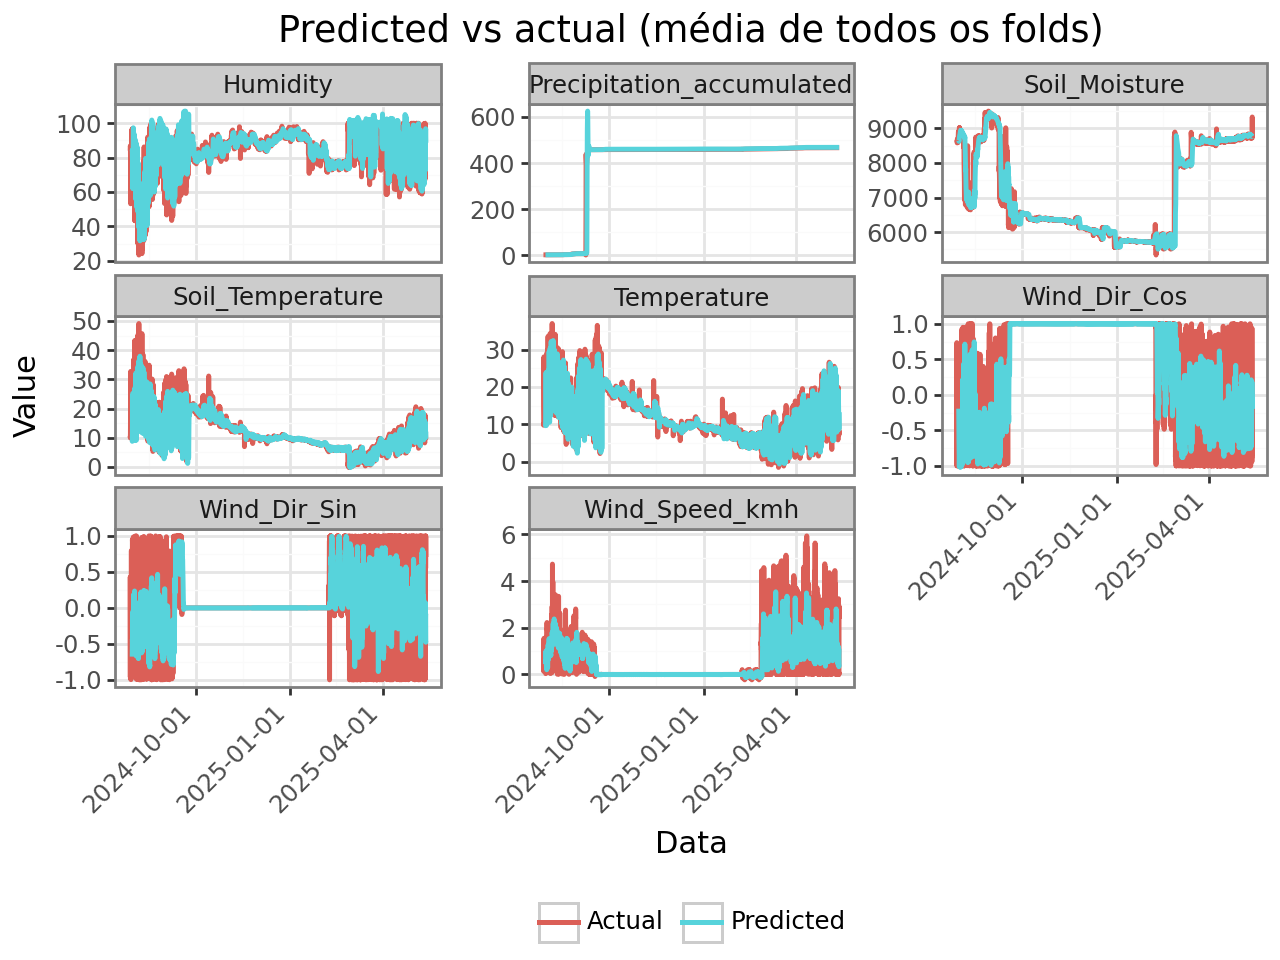

/home/eduardo/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 12 x 10 in image.
/home/eduardo/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: predict_actual_avg.png


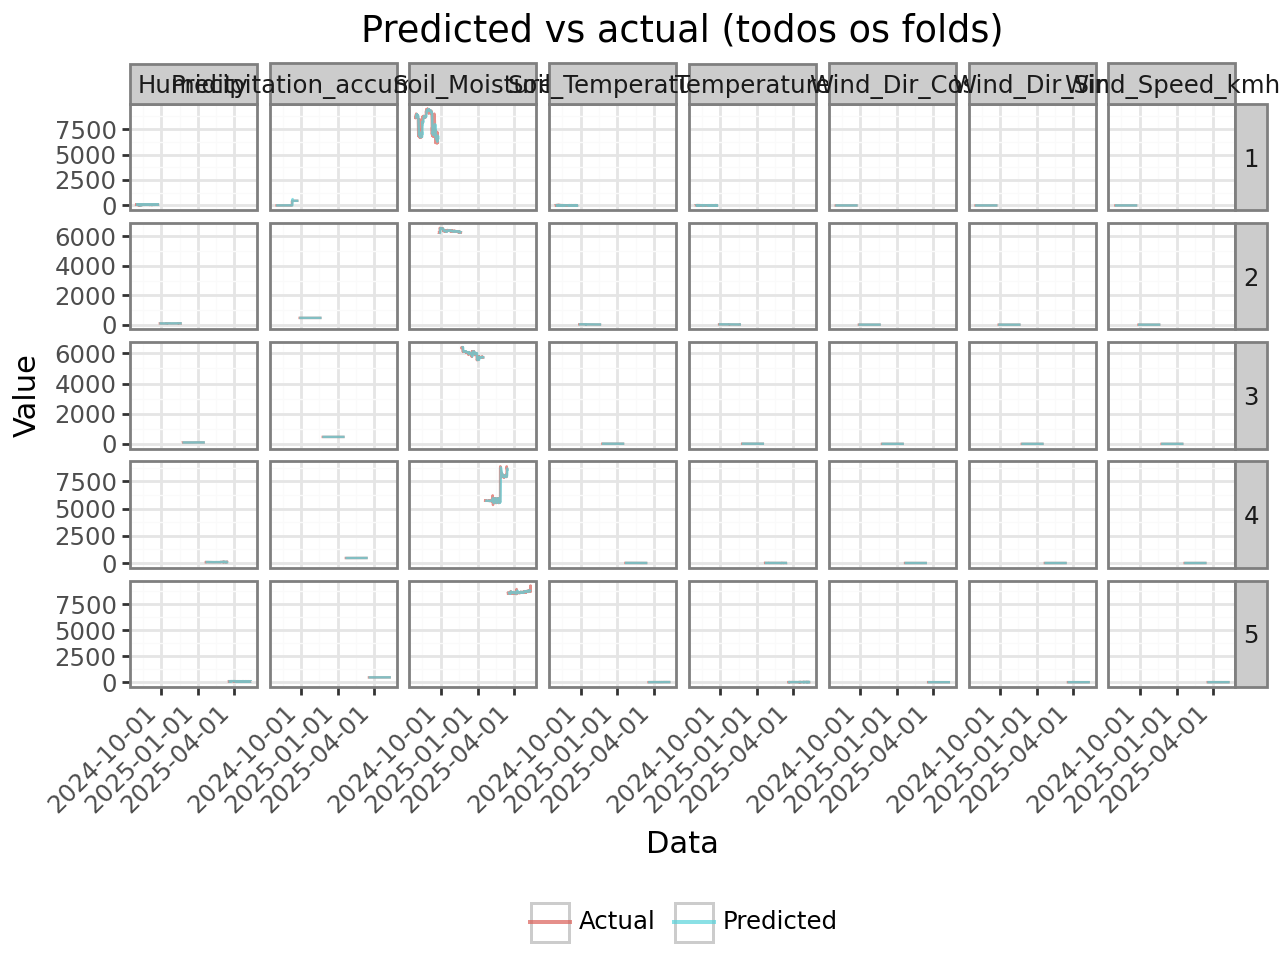

/home/eduardo/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 15 x 20 in image.
/home/eduardo/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: predict_actual_all_folds.png
/tmp/ipykernel_4685/688565223.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


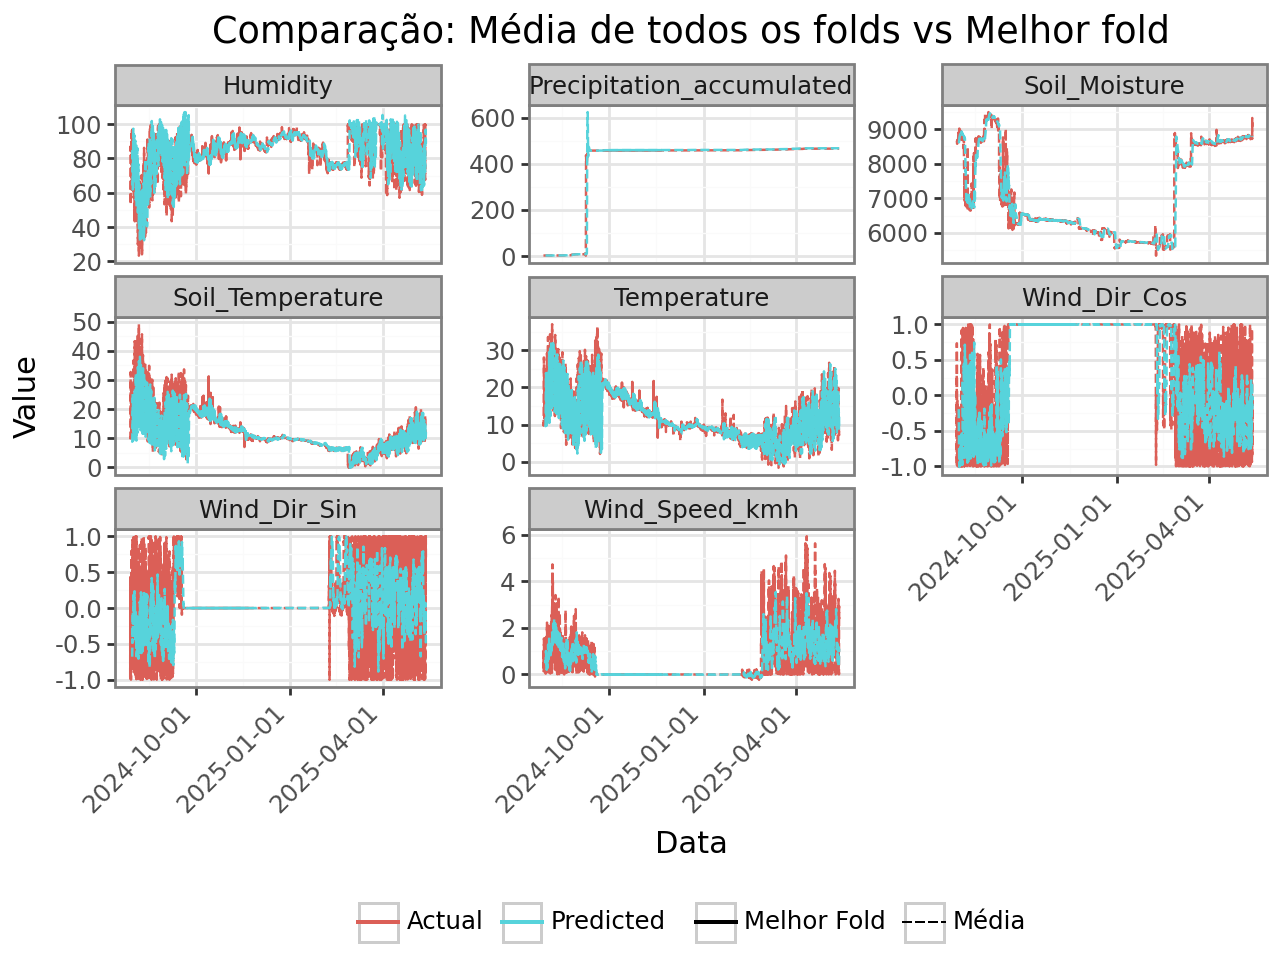

/home/eduardo/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 12 x 10 in image.
/home/eduardo/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: predict_actual_comparison.png


In [7]:
plot_columns = ['Timestamp', 'fold'] + target_columns
s_melted = s_df[plot_columns].melt(
    id_vars=['Timestamp', 'fold'],
    var_name='target_column',
    value_name='value'
)
s_melted['type'] = 'Actual'

forecasts_t_melted = forecasts_t_df[plot_columns].melt(
    id_vars=['Timestamp', 'fold'],
    var_name='target_column',
    value_name='value'
)
forecasts_t_melted['type'] = 'Predicted'

df_combined = pd.concat([s_melted, forecasts_t_melted])

df_combined = df_combined.rename(columns={'Timestamp': 'Date'})

# Também criar uma versão agregada (média) para cada target e timestamp
df_avg = df_combined.groupby(['Date', 'target_column', 'type']).agg({'value': 'mean'}).reset_index()
df_avg['fold'] = 'Média'

# Combinar os dados médios com os dados originais
df_all = pd.concat([df_combined, df_avg])

# Plot 1: Média de todos os folds
plot_avg = (
    ggplot(df_avg, aes(x='Date', y='value', color='type'))
    + geom_line(size=1)
    + facet_wrap('~ target_column', scales='free_y')
    + labs(
        title='Predicted vs actual (média de todos os folds)',
        x='Data',
        y='Value',
        color='Data type'
    )
    + theme_bw()
    + theme(
        axis_text_x=element_text(rotation=45, hjust=1),
        legend_position='bottom',
        legend_title=element_blank(),
    )
)
plot_avg.show()
plot_avg.save('predict_actual_avg.png', width=12, height=10, dpi=300)

# Plot 2: Todos os folds separados por target
plot_all_folds = (
    ggplot(df_combined, aes(x='Date', y='value', color='type'))
    + geom_line(alpha=0.7)
    + facet_grid('fold ~ target_column', scales='free_y')
    + labs(
        title='Predicted vs actual (todos os folds)',
        x='Data',
        y='Value',
        color='Data type'
    )
    + theme_bw()
    + theme(
        axis_text_x=element_text(rotation=45, hjust=1),
        legend_position='bottom',
        legend_title=element_blank(),
        strip_text_y=element_text(angle=0)
    )
)
plot_all_folds.show()
plot_all_folds.save('predict_actual_all_folds.png', width=15, height=20, dpi=300)

# Plot 3: Comparação da média com o melhor fold
# Primeiro, preparar os dados do melhor fold
best_fold_data = df_combined[df_combined['fold'] == best_fold]
best_fold_data['fold'] = 'Melhor Fold'
comparison_data = pd.concat([df_avg, best_fold_data])

plot_comparison = (
    ggplot(comparison_data, aes(x='Date', y='value', color='type', linetype='fold'))
    + geom_line()
    + facet_wrap('~ target_column', scales='free_y')
    + labs(
        title='Comparação: Média de todos os folds vs Melhor fold',
        x='Data',
        y='Value',
        color='Data type'
    )
    + theme_bw()
    + theme(
        axis_text_x=element_text(rotation=45, hjust=1),
        legend_position='bottom',
        legend_title=element_blank(),
    )
)
plot_comparison.show()
plot_comparison.save('predict_actual_comparison.png', width=12, height=10, dpi=300)

In [8]:
# Salvar métricas do melhor fold
with open('best_metrics.json', 'w') as f:
    json.dump(best_metrics.to_dict(), f, indent=4)

# Salvar métricas médias
with open('avg_metrics.json', 'w') as f:
    json.dump(avg_metrics_df.to_dict(), f, indent=4)

# Salvar todas as métricas em um único arquivo
all_metrics = {
    'average': avg_metrics_df.to_dict(),
    'best_fold': best_metrics.to_dict(),
    'all_folds': {f'fold_{i+1}': df.to_dict() for i, df in enumerate(all_metrics_dfs)}
}
with open('all_metrics.json', 'w') as f:
    json.dump(all_metrics, f, indent=4)

print("\nAnálise completa! Os resultados foram salvos usando a média de todos os folds.")



Análise completa! Os resultados foram salvos usando a média de todos os folds.
